In [2]:
import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model

In [3]:
N=5
cities=[i for i in range(N + 1)] # 0th city is the source
edges =[(i,j) for i in cities for j in cities if i!=j]

In [4]:
random=np.random
random.seed(1)
coord_x=random.rand(N + 1)*100
coord_y=random.rand(N + 1)*100

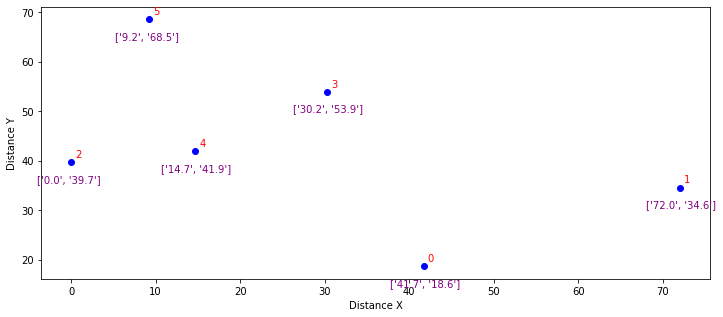

In [5]:
x=coord_x
y=coord_y

plt.figure(figsize=(12,5))
plt.scatter(x,y,color='blue')
s=[]
for n in range(len(coord_x)):
    s_temp=[]
    s_temp.append("%.1f" %coord_x[n])
    s_temp.append("%.1f" %coord_y[n])
    s.append(s_temp)

plt.xlabel("Distance X")
plt.ylabel("Distance Y")

for n in range(len(coord_x)):
    plt.annotate(str(s[n]), xy=(coord_x[n],coord_y[n] ), xytext=(coord_x[n]-4,coord_y[n]-4), 
                 color='purple')
    
for n in range(len(coord_x)):
    plt.annotate(str(n), xy=(coord_x[n],coord_y[n] ), xytext=(coord_x[n]+0.5,coord_y[n]+1),
                 color='red')

plt.show()

In [6]:
distances={(i, j): np.hypot(coord_x[i] - coord_x[j], coord_y[i] - coord_y[j]) for i,j in edges}

In [7]:
service_times = [0] + list(random.rand(N)*100)
costs = {(i, j): distances[(i, j)] + service_times[i] for (i,j) in distances}

In [74]:
# for model A, we have N cities. Each city can be visited in 1st place, 2nd, .. Nth place.abs
arc_layers = {}
for k in range(1, N): # position in permutation
    for i in range(1, N + 1):
        for j in range(1, N + 1):
            if i == j:
                continue
            arc_layers[(i, j, k)] = costs[(i, j)] * (N - k)

choice_at_level = {(i, k) for i in range(1, N + 1) for k in range(1, N + 1)}

In [75]:

len(choice_at_level)

25

In [76]:

len(arc_layers)

80

In [77]:
# TODO This doesnt match the paper. I calculate N * (N-1)**2 different real params
N**3 - 2*N**2 + 2*N

85

In [60]:
mdl=Model('MLP')

x = mdl.binary_var_dict(choice_at_level,name='x')
y = mdl.continuous_var_dict(arc_layers,name='y')

In [78]:
z = N * mdl.sum(costs[(0, i)] * x[(i, 1)] for i in range(1, N+1)) + mdl.sum(arc_layers[i] * y[i] for i in arc_layers)
mdl.minimize(z)

In [79]:
num_constraints = 0
for k in range(1, N + 1):
    mdl.add_constraint(
        mdl.sum(x[(i,k)] for i in range(1, N + 1)) == 1
    )
    num_constraints += 1
for i in range(1, N + 1):
    mdl.add_constraint(
        mdl.sum(x[(i,k)] for k in range(1, N + 1)) == 1
    )
    num_constraints += 1

for i in range(1, N + 1):
    for k in range(1, N):
        mdl.add_constraint(
            mdl.sum(y[(i, j, k)] for j in range(1, N + 1) if j != i) == x[(i, k)]
        )
        num_constraints += 1
    
for j in range(1, N + 1):
    for k in range(1, N):
        mdl.add_constraint(
            mdl.sum(y[(i, j, k)] for i in range(1, N + 1) if j != i) == x[(j, k+1)]
        )
        num_constraints += 1

print(num_constraints)

50


In [80]:
mdl.parameters.timelimit=120
mdl.parameters.mip.strategy.branch=1
mdl.parameters.mip.tolerances.mipgap=0.15

solution = mdl.solve(log_output=True)

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
CPXPARAM_MIP_Strategy_Branch                     1
CPXPARAM_TimeLimit                               120
CPXPARAM_MIP_Tolerances_MIPGap                   0.14999999999999999
3 of 3 MIP starts provided solutions.
MIP start 'm1' defined initial solution with objective 741.9414.
Tried aggregator 2 times.
MIP Presolve eliminated 50 rows and 0 columns.
Aggregator did 5 substitutions.
Reduced MIP has 45 rows, 100 columns, and 255 nonzeros.
Reduced MIP has 20 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.25 ticks)
Probing time = 0.00 sec. (0.09 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 45 rows, 100 columns, and 255 nonzeros.
Reduced MIP has 20 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.14 ticks)
Probing time = 0.00 sec. (0.09 ticks)
Clique

In [81]:
mdl.get_solve_status()

<JobSolveStatus.OPTIMAL_SOLUTION: 2>

In [82]:
solution.display()

solution for: MLP
objective: 741.941
x_2_5 = 1
x_4_4 = 1
x_1_1 = 1
x_3_2 = 1
x_5_3 = 1
y_1_3_1 = 1.000
y_3_5_2 = 1.000
y_5_4_3 = 1.000
y_4_2_4 = 1.000


In [83]:
import itertools
min_cost = np.inf
def compute_cost(perm):
    cost = costs[(0, perm[0])] * N
    for index, edge in enumerate(zip(perm[:-1], perm[1:])):
        cost += costs[edge] * (N - (index + 1))
    return cost
for permutation in itertools.permutations(list(range(1, N + 1))):
    cost = compute_cost(permutation)
    if cost < min_cost:
        best = permutation
        min_cost = cost

In [84]:
min_cost, best

(741.9414483101717, (1, 3, 5, 4, 2))

In [87]:
permutation = [0]
for k in range(1, N + 1):
    for i in range(1, N + 1):
        if x[(i, k)].solution_value == 1:
            permutation.append(i)
            break

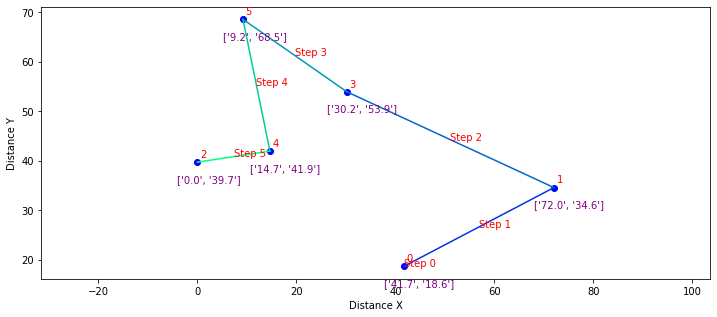

In [98]:
x=coord_x
y=coord_y

plt.figure(figsize=(12,5))
plt.scatter(x,y,color='blue')
s=[]
for n in range(len(coord_x)):
    s_temp=[]
    s_temp.append("%.1f" %coord_x[n])
    s_temp.append("%.1f" %coord_y[n])
    s.append(s_temp)

plt.xlabel("Distance X")
plt.ylabel("Distance Y")

for n in range(len(coord_x)):
    plt.annotate(str(s[n]), xy=(coord_x[n],coord_y[n] ), xytext=(coord_x[n]-4,coord_y[n]-4), 
                 color='purple')
    
for n in range(len(coord_x)):
    plt.annotate(str(n), xy=(coord_x[n],coord_y[n] ), xytext=(coord_x[n]+0.5,coord_y[n]+1),
                 color='red')



cmap = plt.get_cmap('winter')
for step, (i, j) in enumerate(zip([0] + permutation[:-1], permutation)):
    plt.plot([coord_x[i], coord_x[j]], [coord_y[i], coord_y[j]], c=cmap(step/N))
    
    plt.annotate(f"Step {step}", xy=((coord_x[i] + coord_x[j])/2, (coord_y[i] + coord_y[j])/2),
                 color='red')

plt.axis('equal');

plt.show()